In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
import tqdm
np.set_printoptions(precision=4)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import LambdaLR
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.nn.functional as F
from einops import rearrange, reduce
import pytorch_warmup as warmup

from gpt_adaln_core import Transformer
# from gpt_core import Transformer, EMA

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
rb_pos_world = np.zeros((8,8,2))
kdtree_positions_world = np.zeros((64, 2))
for i in range(8):
    for j in range(8):
        if i%2!=0:
            finger_pos = np.array((i*0.0375, j*0.043301 - 0.02165))
            rb_pos_world[i,j] = np.array((i*0.0375, j*0.043301 - 0.02165))
        else:
            finger_pos = np.array((i*0.0375, j*0.043301))
            rb_pos_world[i,j] = np.array((i*0.0375, j*0.043301))
        kdtree_positions_world[i*8 + j, :] = rb_pos_world[i,j]

np.min(kdtree_positions_world, axis=0), np.max(kdtree_positions_world, axis=0)

(array([ 0.    , -0.0216]), array([0.2625, 0.3031]))

In [3]:
import numpy as np
import pickle as pkl
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import torch

class ImitationDataset(Dataset):
    def __init__(self, states, actions, next_states, pos, num_agents, rewards, done):
        self.states = states
        self.actions = actions
        self.next_states = next_states
        self.pos = pos
        self.num_agents = num_agents
        self.rewards = rewards
        self.done = done

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        state = self.states[idx]
        action = self.actions[idx]
        next_states = self.next_states[idx]
        pos = self.pos[idx]
        num_agents = self.num_agents[idx]
        reward = self.rewards[idx]
        done = self.done[idx]
        return state, action, next_states, pos, reward, done, num_agents

def get_smol_dataset(states, actions, next_states, pos, num_agents, rewards, done, num_samples:int=None):
    if num_samples is None:
        return ImitationDataset(states, actions, next_states, pos, num_agents, rewards, done)
        
    chosen_indices = np.random.choice(np.arange(len(states)), num_samples, replace=False)
    final_indices = np.array(chosen_indices)

    smol_states = states[final_indices]
    smol_actions = actions[final_indices]
    smol_next_states = next_states[final_indices]
    smol_pos = pos[final_indices]
    smol_num_agents = num_agents[final_indices]
    smol_rewards = rewards[final_indices]
    smol_done = done[final_indices]
    return ImitationDataset(smol_states, smol_actions, smol_next_states, smol_pos, smol_num_agents, smol_rewards, smol_done)

def split_dataset(dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)
    # test size is the remainder

    np.random.shuffle(indices)
    
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size+val_size]
    test_indices = indices[train_size+val_size:]

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    test_dataset = Subset(dataset, test_indices)

    return train_dataset, val_dataset, test_dataset

def get_dataset_and_dataloaders(
    train_bs:int=128,
    val_bs:int=128,
    test_bs:int=1,
    actor_num_samples=1000,
    critic_num_samples=10000,
    rb_path='../../data/replay_buffer_mixed.pkl'
):
    replay_buffer = pkl.load(open(rb_path, 'rb'))

    obs = replay_buffer['obs']
    act = replay_buffer['act']
    obs2 = replay_buffer['obs2']
    pos = replay_buffer['pos']
    num_agents = replay_buffer['num_agents']
    rewards = replay_buffer['rew']
    done = replay_buffer['done']

    # Actor: only actions with rewards > 30
    actor_idxs = np.where(rewards > 30)[0]
    actor_dataset = get_smol_dataset(
        obs[actor_idxs], act[actor_idxs], obs2[actor_idxs],
        pos[actor_idxs], num_agents[actor_idxs],
        rewards[actor_idxs], done[actor_idxs],
        num_samples=actor_num_samples
    )

    # Split actor dataset
    actor_train_dataset, actor_val_dataset, actor_test_dataset = split_dataset(actor_dataset)
    actor_train_loader = DataLoader(actor_train_dataset, batch_size=train_bs, shuffle=True)
    actor_val_loader = DataLoader(actor_val_dataset, batch_size=val_bs, shuffle=False)
    actor_test_loader = DataLoader(actor_test_dataset, batch_size=test_bs, shuffle=False)

    # Critic: Combine good and bad experiences into one dataset
    critic_good_idxs = np.where(rewards > 50)[0]
    critic_bad_idxs = np.where((rewards <= 50) & (rewards > -20) & (rewards != 0))[0]
    critic_all_idxs = np.concatenate([critic_good_idxs, critic_bad_idxs])

    critic_dataset = get_smol_dataset(
        obs[critic_all_idxs], act[critic_all_idxs], obs2[critic_all_idxs],
        pos[critic_all_idxs], num_agents[critic_all_idxs],
        rewards[critic_all_idxs], done[critic_all_idxs],
        num_samples=critic_num_samples
    )

    critic_train_loader = DataLoader(critic_dataset, batch_size=train_bs, shuffle=True)

    return actor_train_loader, actor_val_loader, actor_test_loader, critic_train_loader


In [4]:
num_samples = 10000
actor_train_loader, actor_val_loader, actor_test_loader, critic_train_loader = get_dataset_and_dataloaders(
    train_bs=256,
    val_bs=256,
    test_bs=1,
    actor_num_samples=num_samples,
    critic_num_samples=num_samples*5,
    rb_path='../../data/replay_buffer_mixed_new.pkl'
)


In [5]:
len(actor_train_loader), len(actor_val_loader), len(actor_test_loader)

(28, 6, 1500)

In [6]:
# print(state_scaler.scaler.mean_, state_scaler.scaler.var_, action_scaler.scaler.mean_, action_scaler.scaler.var_, obj_name_encoder.classes_)

# dic = {'state_scaler': state_scaler, 'action_scaler': action_scaler, 'obj_name_encoder': obj_name_encoder}
# pkl.dump(dic, open('normalizer_bc.pkl', 'wb'))

In [20]:
n_epochs = 400
hp_dict = {
        "exp_name"          : "MABC",
        "data_dir"          : "./data/rl_data",
        'warmup_iters'      : 2,
        'pi_lr'             : 1e-4,
        'pi_eta_min'        : 1e-6,
        'q_lr'              : 1e-6,
        'q_eta_min'         : 1e-8,
        'epochs'            : n_epochs,
        'ckpt_dir'          : './matil_expt_1.pth',
        'idx_embed_loc'     : './idx_embedding_new.pth',

        # DiT Params:
        'state_dim'         : 6,
        'action_dim'        : 3,
        'act_limit'         : 0.03,
        'gamma'             : 0.99,
        "dev_rl"            : torch.device(f"cuda:0"),
        "model_dim"         : 256,
        "num_heads"         : 8,
        "dim_ff"            : 512,
        "n_layers_dict"     : {'encoder':5, 'actor': 10, 'critic': 10},
        "dropout"           : 0,
        "max_grad_norm"     : 1,
        'gauss'             : True,
        'masked'            : True,
        'adaln'             : True,
        'attn_mech'         : 'AdaLN',

        "denoising_params"  :{
            'num_train_timesteps'   : 1000,
            'beta_start'        : 0.0001,
            'beta_end'          : 0.02,
            'beta_schedule'     : 'linear',
            'variance_type'     : 'fixed_small_log',
            'clip_sample'       : True ,
            'prediction_type'   : 'epsilon',
        },

        "EMA Params":{
            'update_after_step' : 0,
            'inv_gamma'         : 1.0,
            'power'             : 0.75,
            'min_value'         : 0.5,
            'max_value'         : 0.9999,
        }
    }
# Implementation TODOs:
#   1. Add KL Divergence loss
#   2. Add normalization
#   3. Add CAWR        

model = Transformer(hp_dict)
# ema_model = deepcopy(model).to(hp_dict['device'])
model.to(hp_dict['dev_rl'])
# optimizer = optim.SGD(model.parameters(), lr=hp_dict['lr'])
optimizer_actor = optim.AdamW(model.decoder_actor.parameters(), lr=hp_dict['pi_lr'], weight_decay=1e-2)
optimizer_critic = optim.AdamW(model.decoder_critic.parameters(), lr=hp_dict['q_lr'], weight_decay=1e-2)

# optimizer = optim.SGD(model.parameters(), lr=1e-2)
lr_scheduler_actor = CosineAnnealingWarmRestarts(optimizer_actor, T_0=20, T_mult=2, eta_min=hp_dict['pi_eta_min'])
lr_scheduler_critic = CosineAnnealingWarmRestarts(optimizer_critic, T_0=20, T_mult=2, eta_min=hp_dict['q_eta_min'])
model.load_state_dict(torch.load('../../models/trained_models/mabc_ft_sel_acts_pb.pt', weights_only=False, map_location=hp_dict['dev_rl'])['model'])

<All keys matched successfully>

In [21]:
import plotly.io as pio
pio.renderers.default = 'notebook'
import plotly.graph_objects as go


model.eval()
loss = []
statesss = []
actionsss = []
actions_gt = []
possss = []

grand_data = np.zeros((100, 128, 10, 2))
with torch.no_grad():
    with tqdm.tqdm(actor_test_loader, desc=f"Validation", leave=False, mininterval=1) as v:
        for i, (s1, a, s2, p, r, d, N) in enumerate(v):
            N = int(torch.max(N))
            
            actions = a[:1, :N].to(hp_dict['dev_rl'])
            actions_gt.append(actions)

            # Conditioning Variables
            states = s1[:1, :N].to(hp_dict['dev_rl'])
            statesss.append(states)
            next_states = s2[:, :N].to(hp_dict['dev_rl'])
            # print(actions, states)
            pos = p[:1, :N].to(hp_dict['dev_rl'])
            possss.append(pos)
    
            output_actions = model.get_actions_visualize(states, pos, deterministic=True)
            # output_actions = model.get_actions_roundrobin(states, pos, deterministic=True)
            
            print(len(output_actions))
            actionsss.append(output_actions)
            loss.append((actions[:1, :N].cpu().detach().numpy() - output_actions[-1][:,:,:2].cpu().detach().numpy()).mean()**2)
            
            if i>10:
                break


10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10


np.float32(4.1353764e-05)

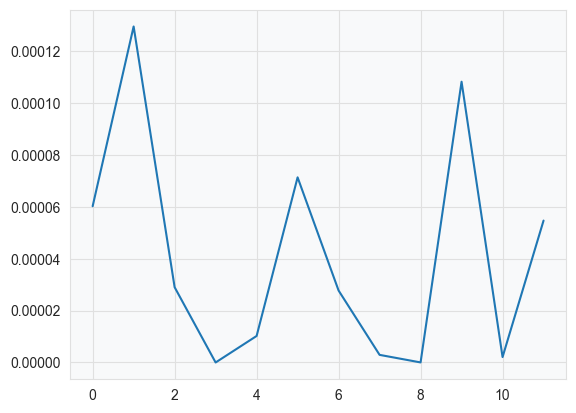

In [22]:
plt.plot(loss)
np.mean(loss)

0 0


/tmp/ipykernel_3217166/2906707099.py:135: UserWarning:

The figure layout has changed to tight



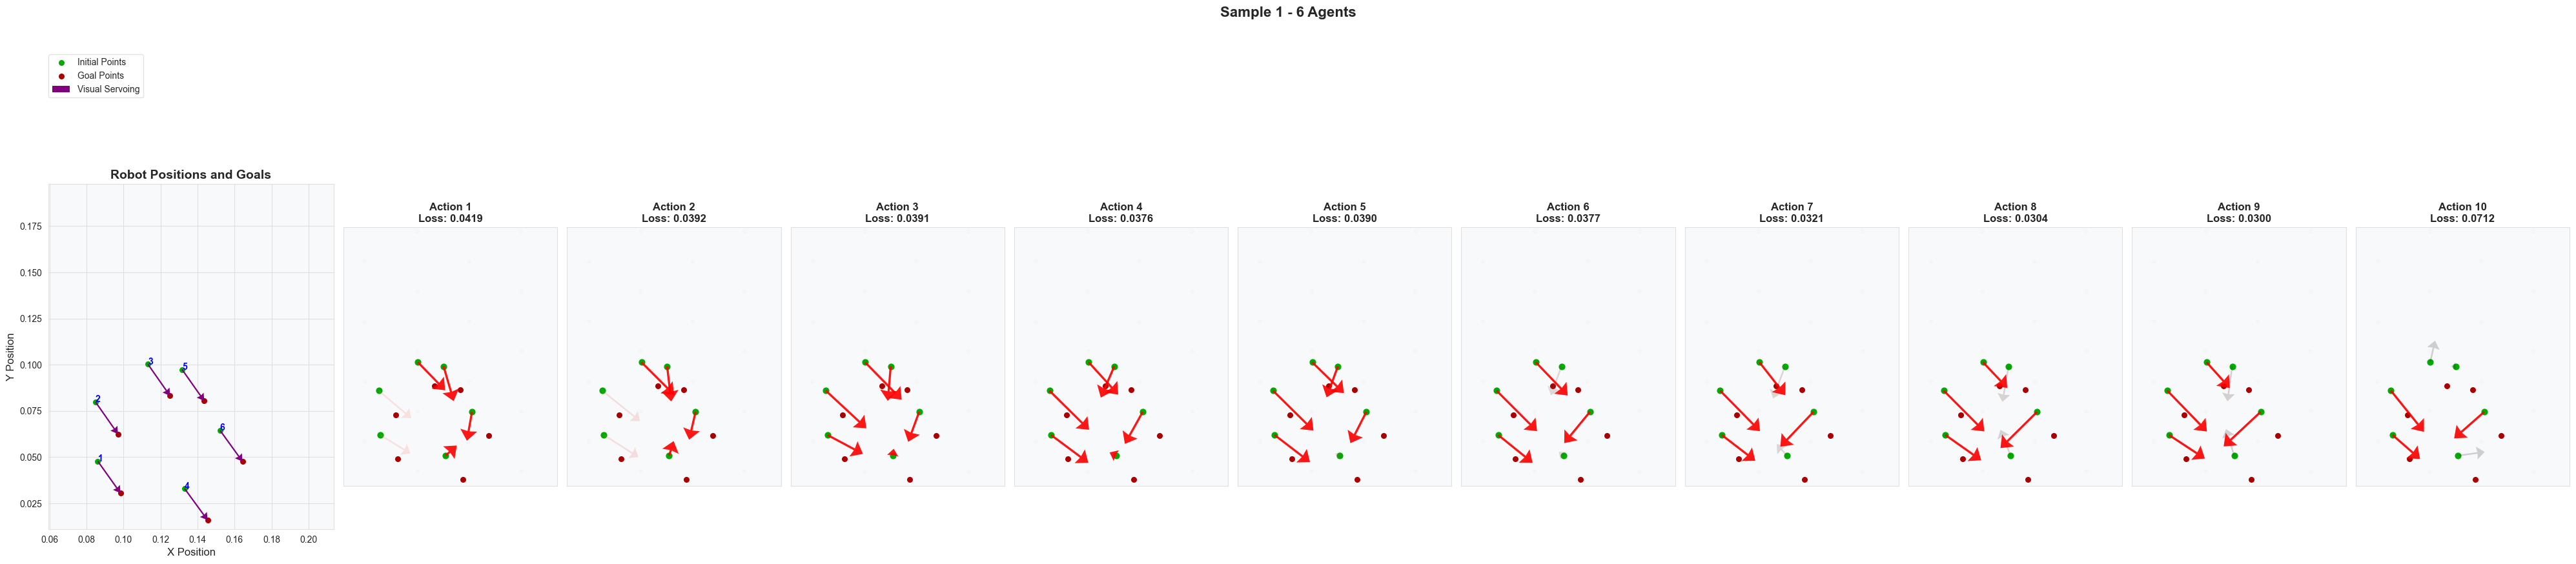

0 0


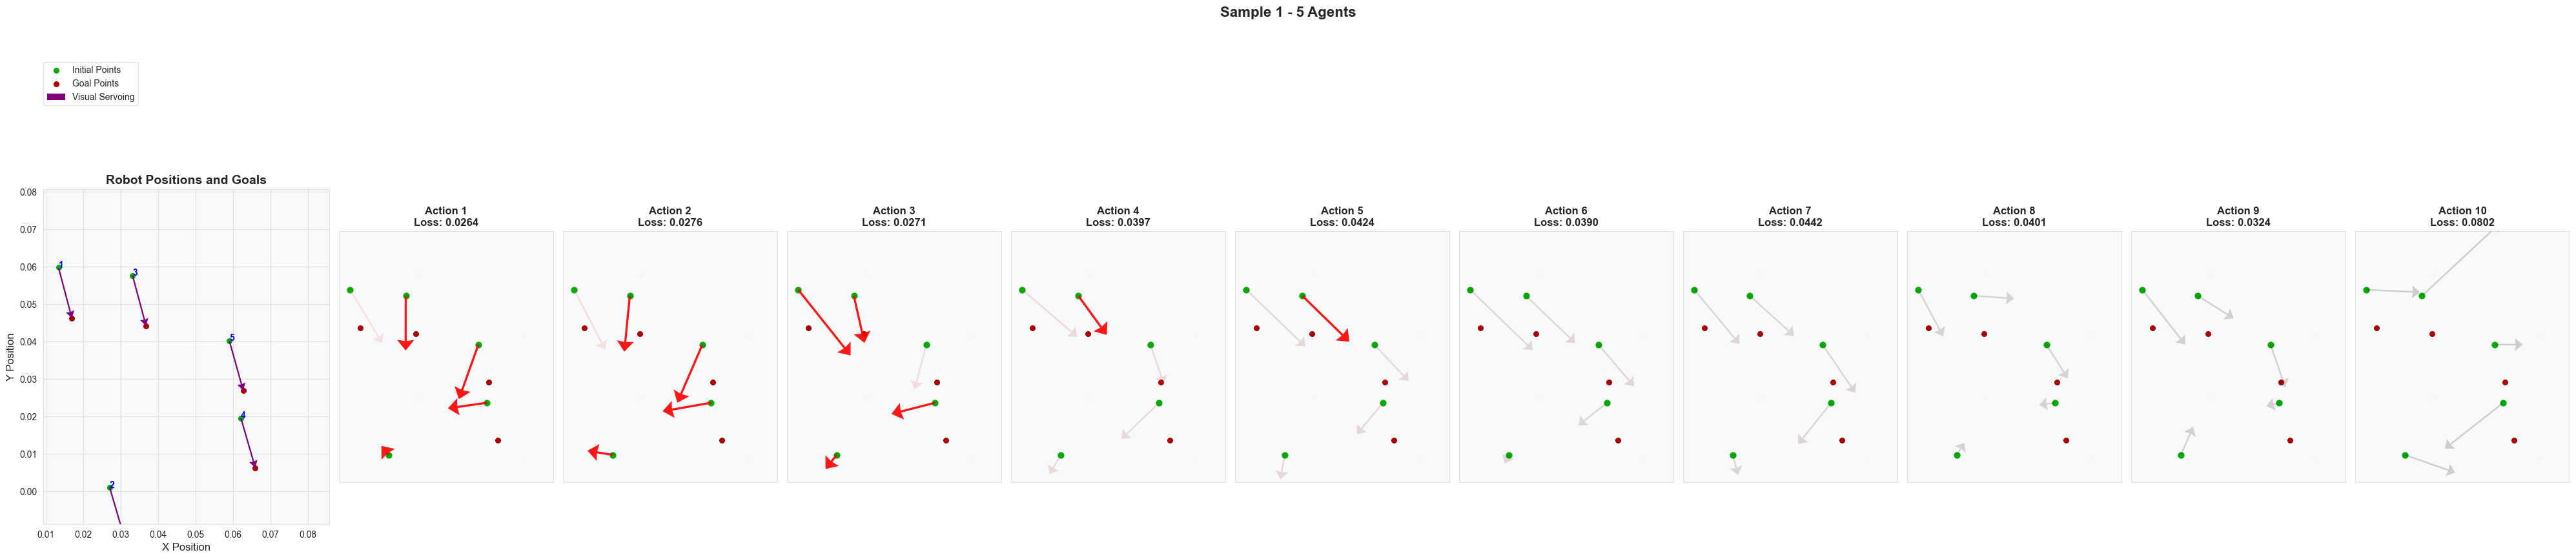

0 0


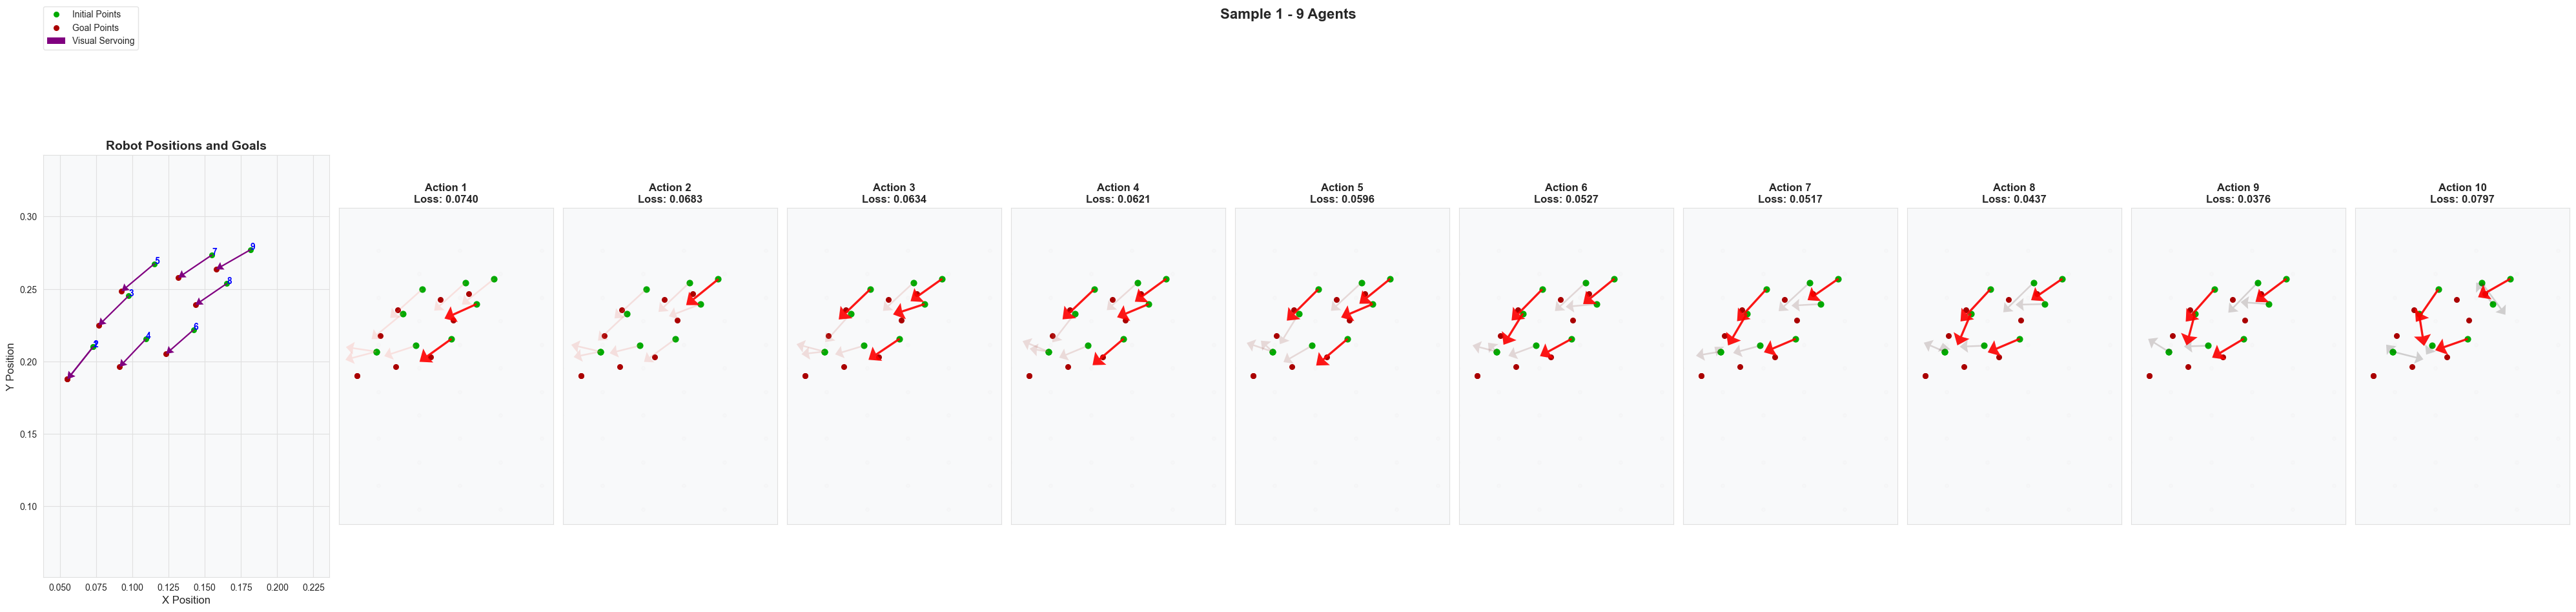

0 0


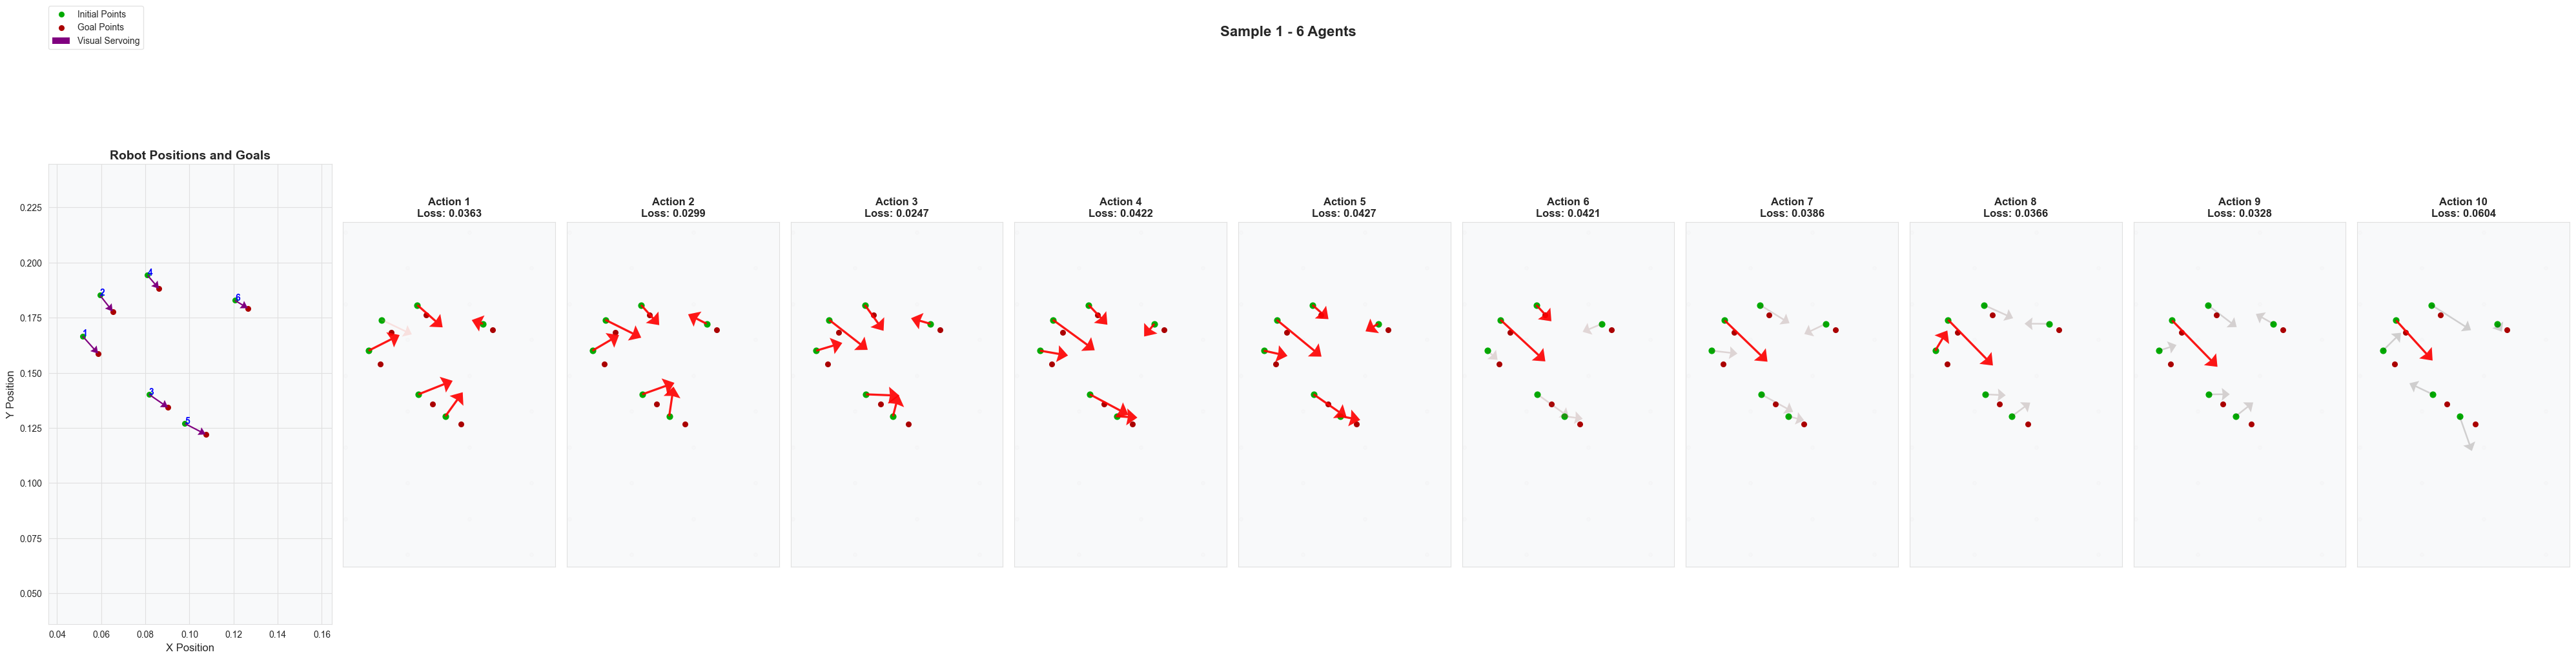

0 0


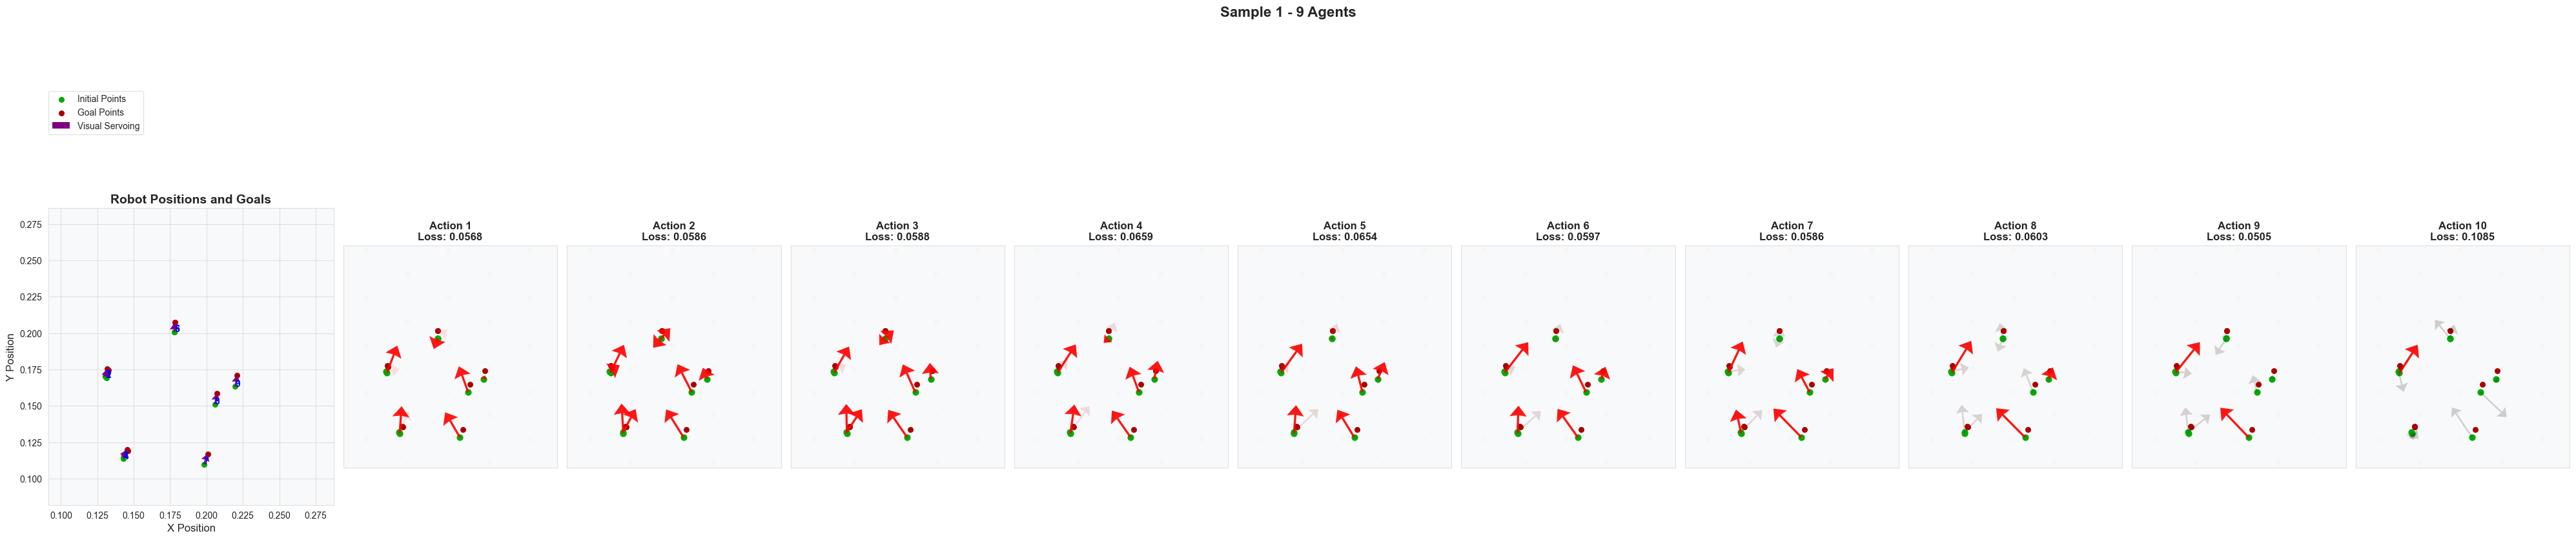

0 0


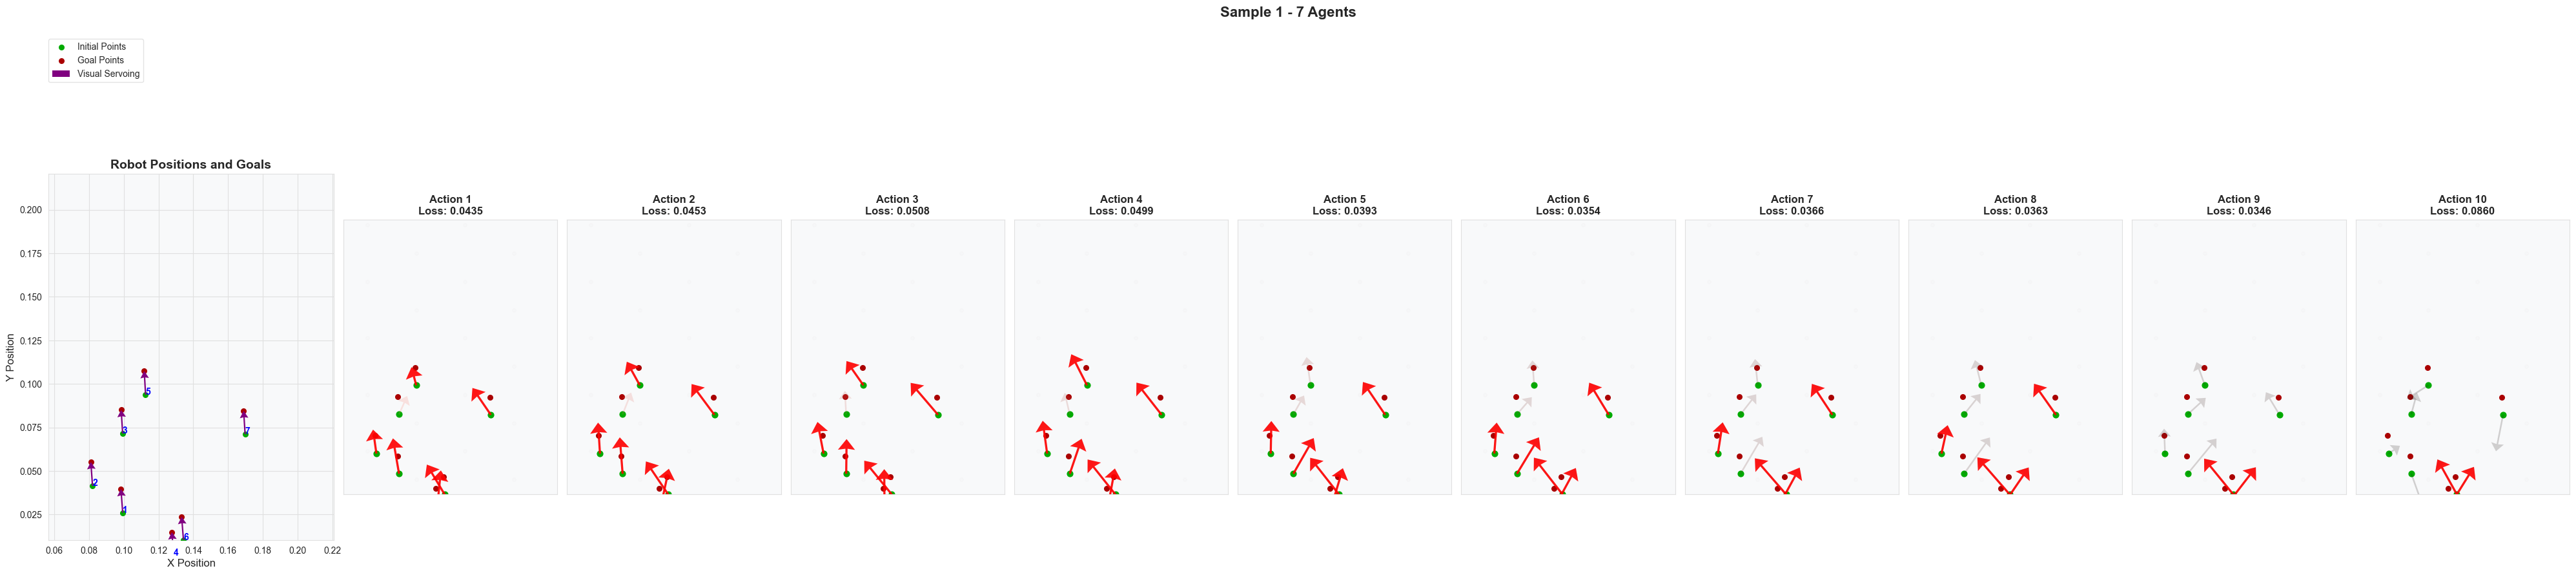

0 0


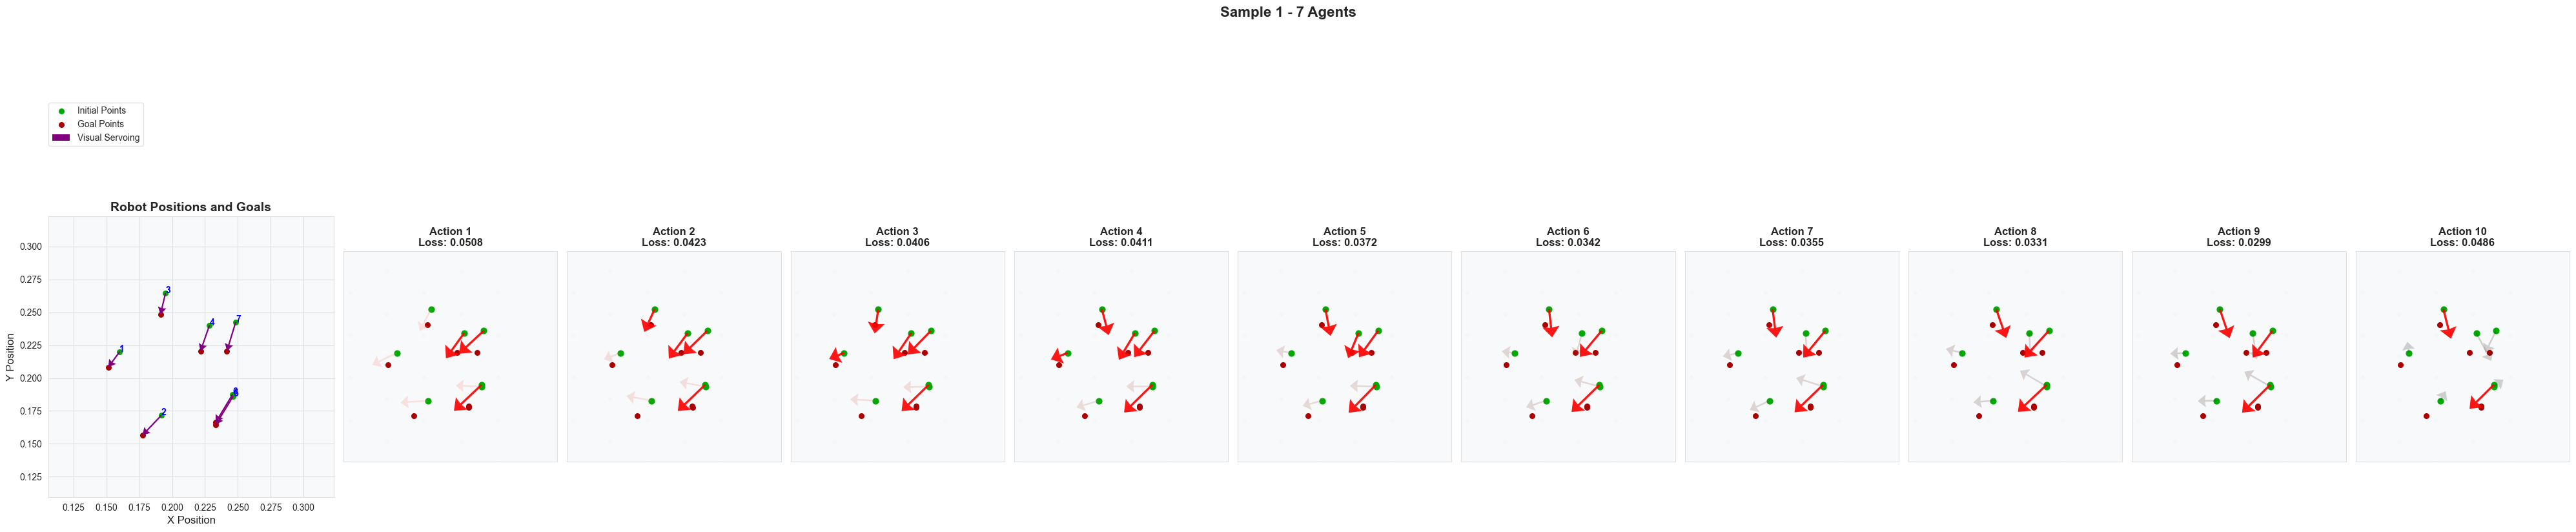

0 0


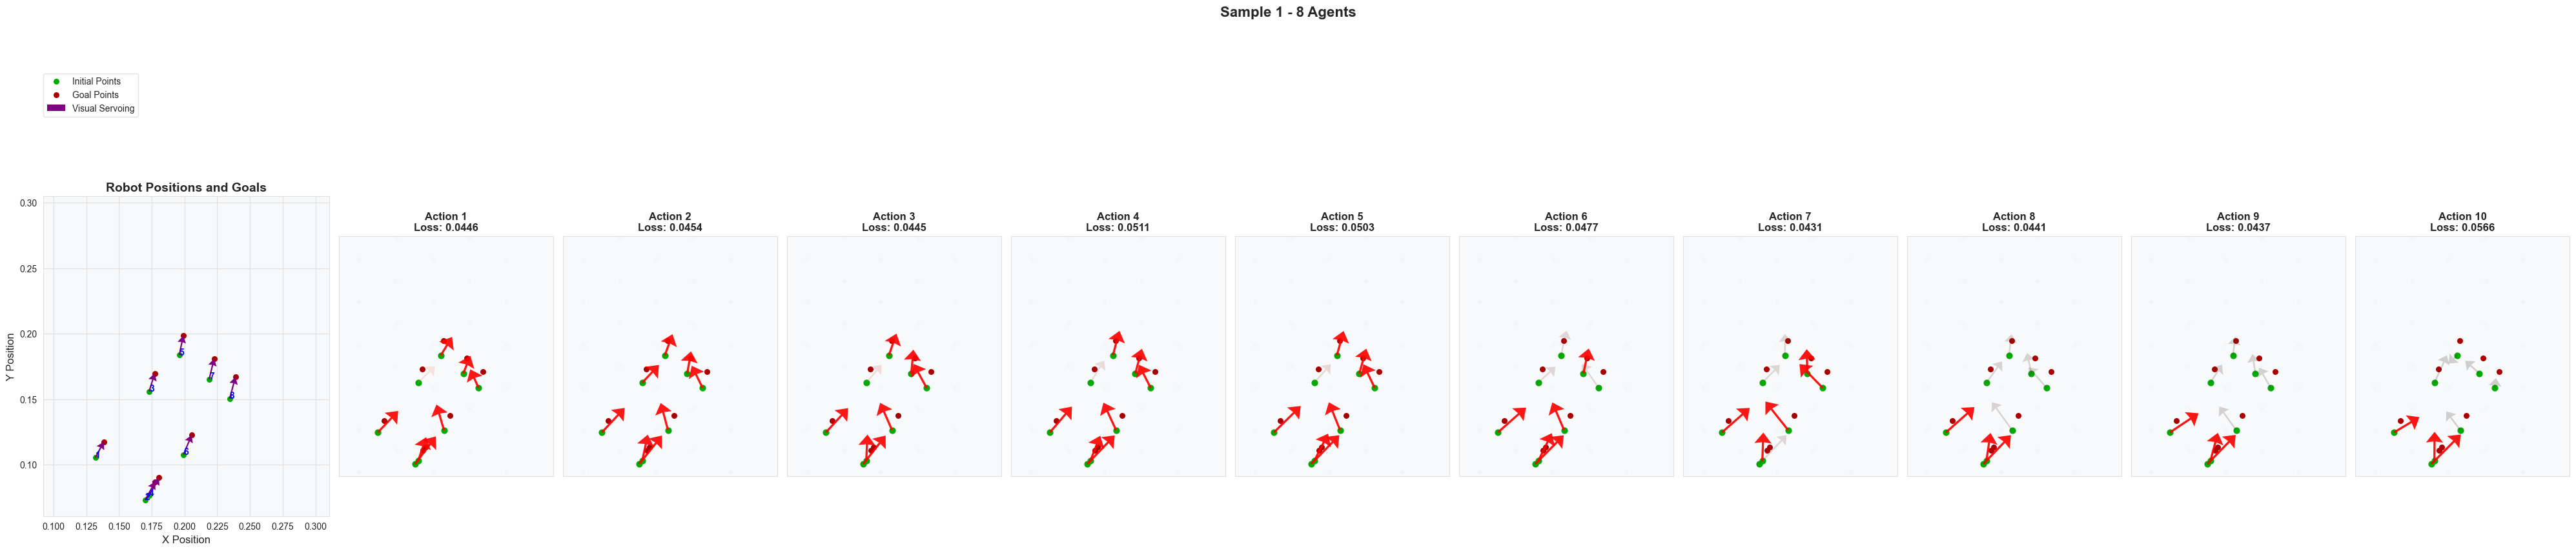

0 0


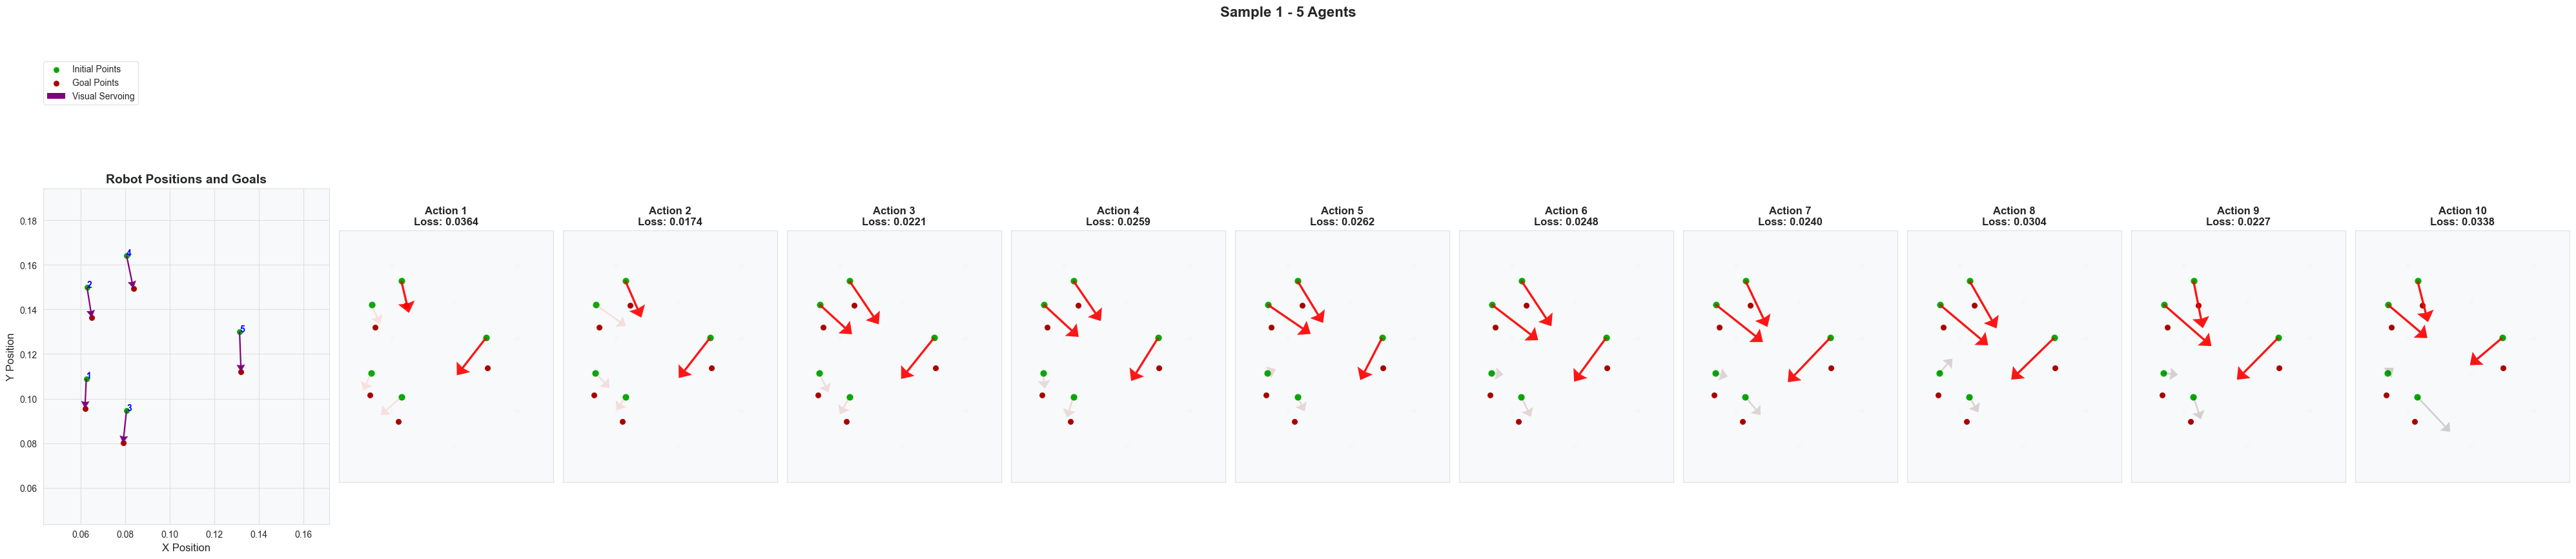

0 0


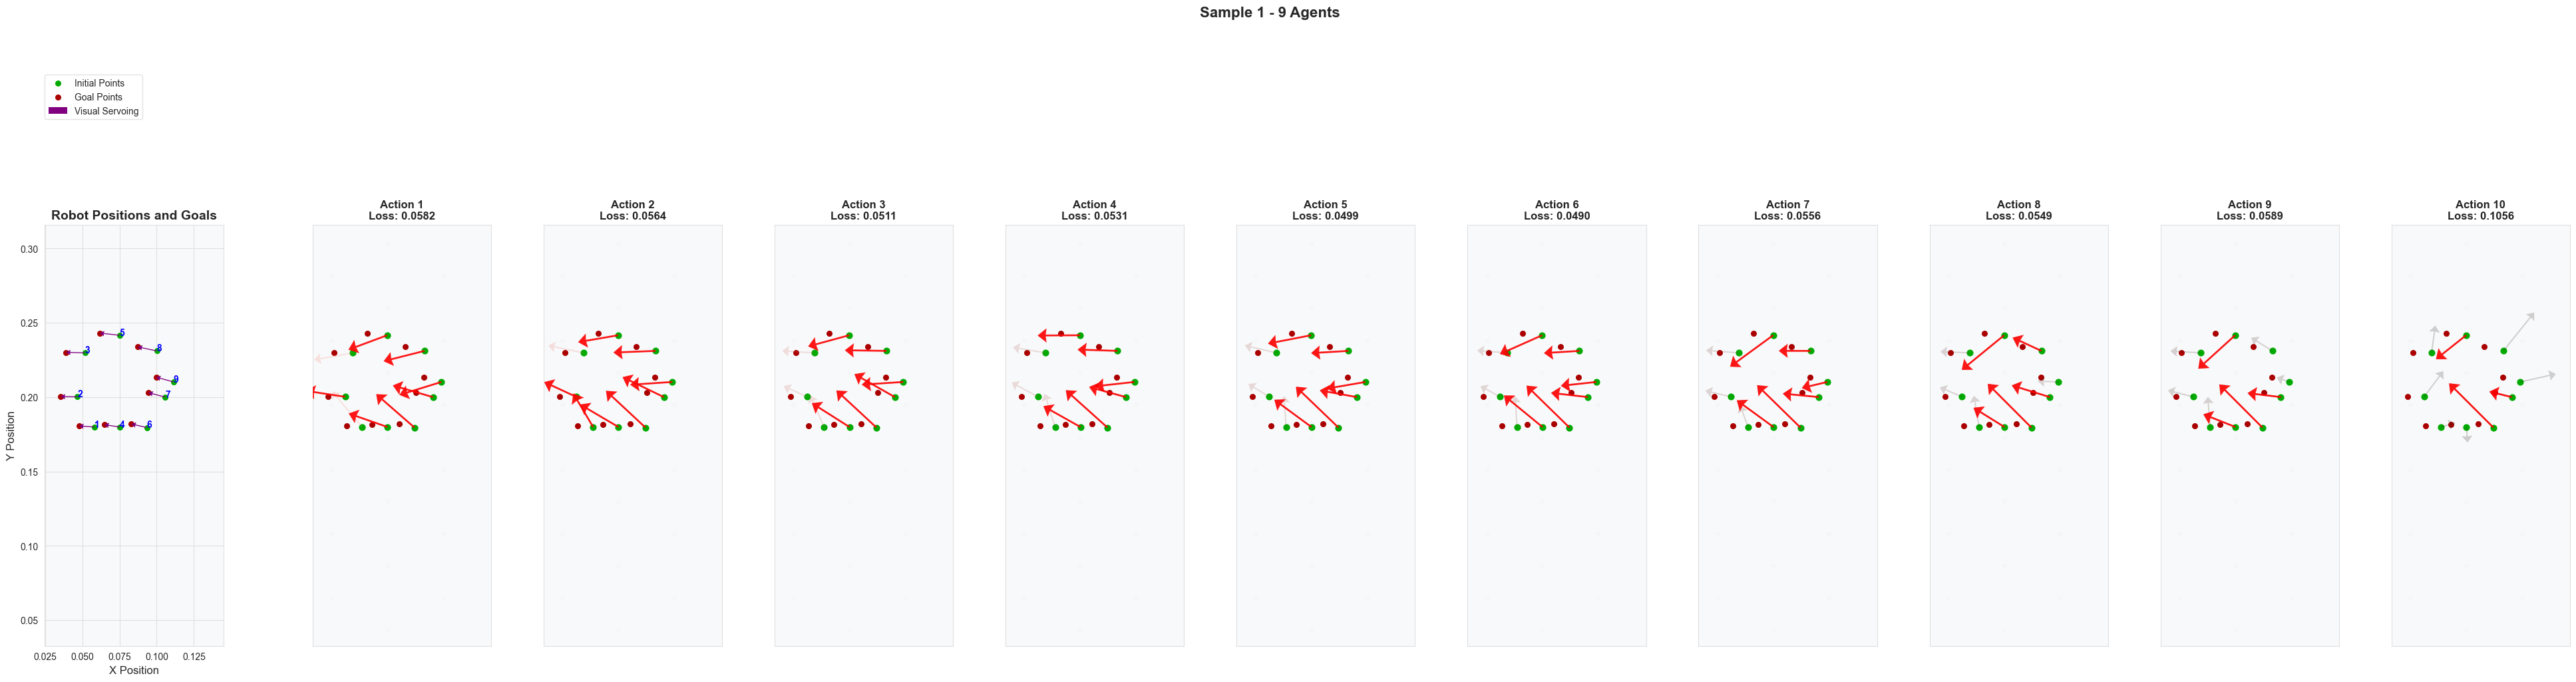

0 0


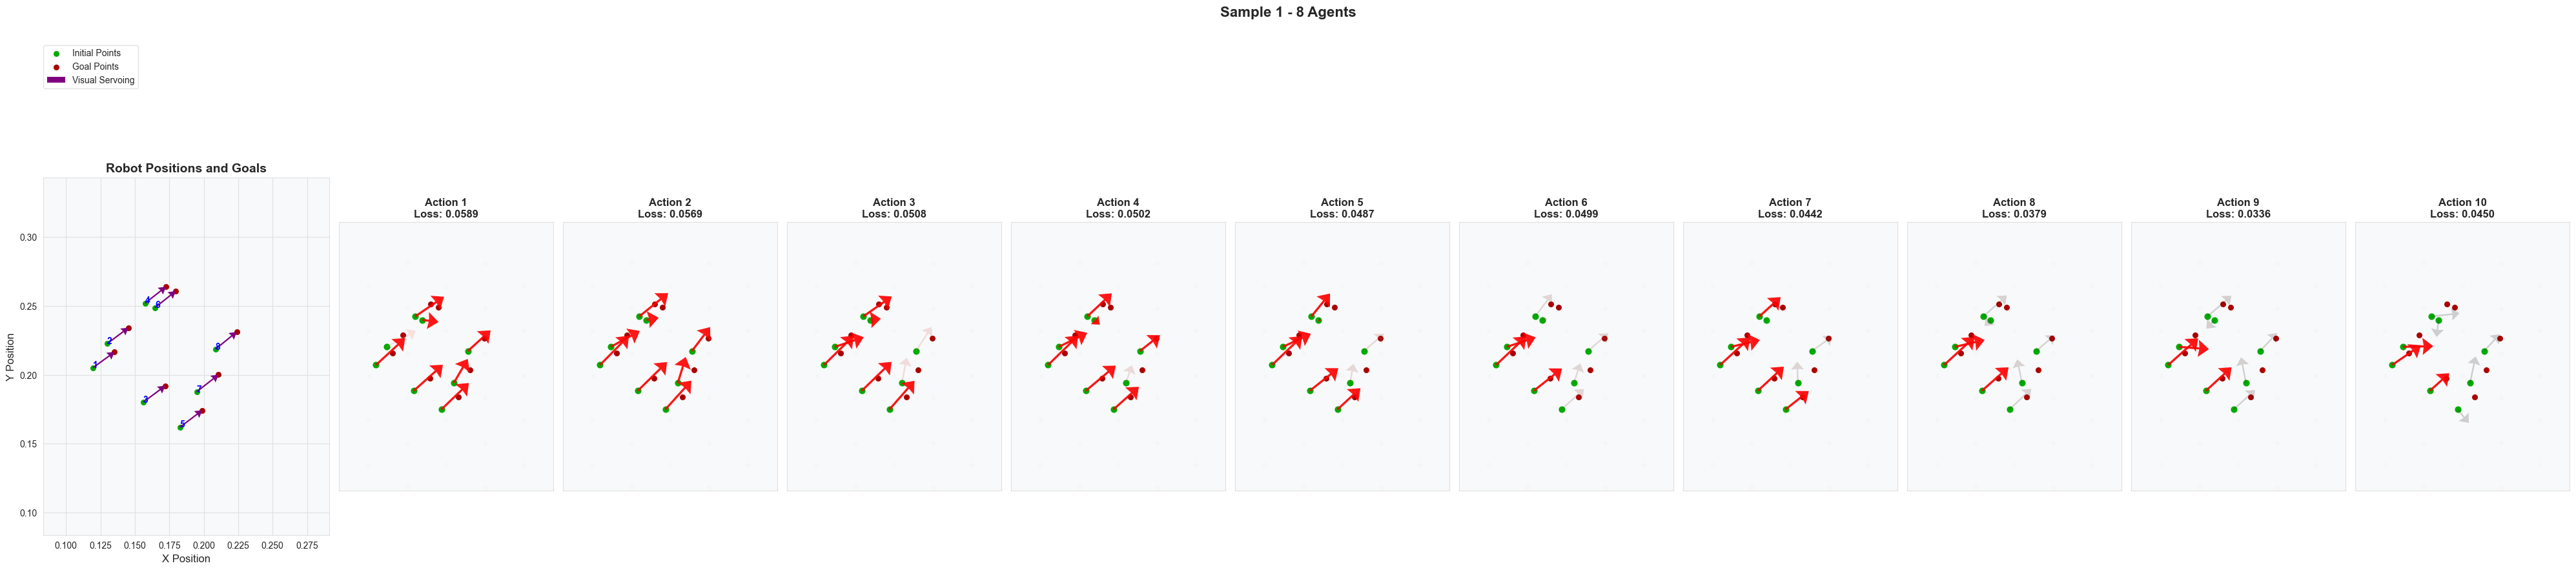

0 0


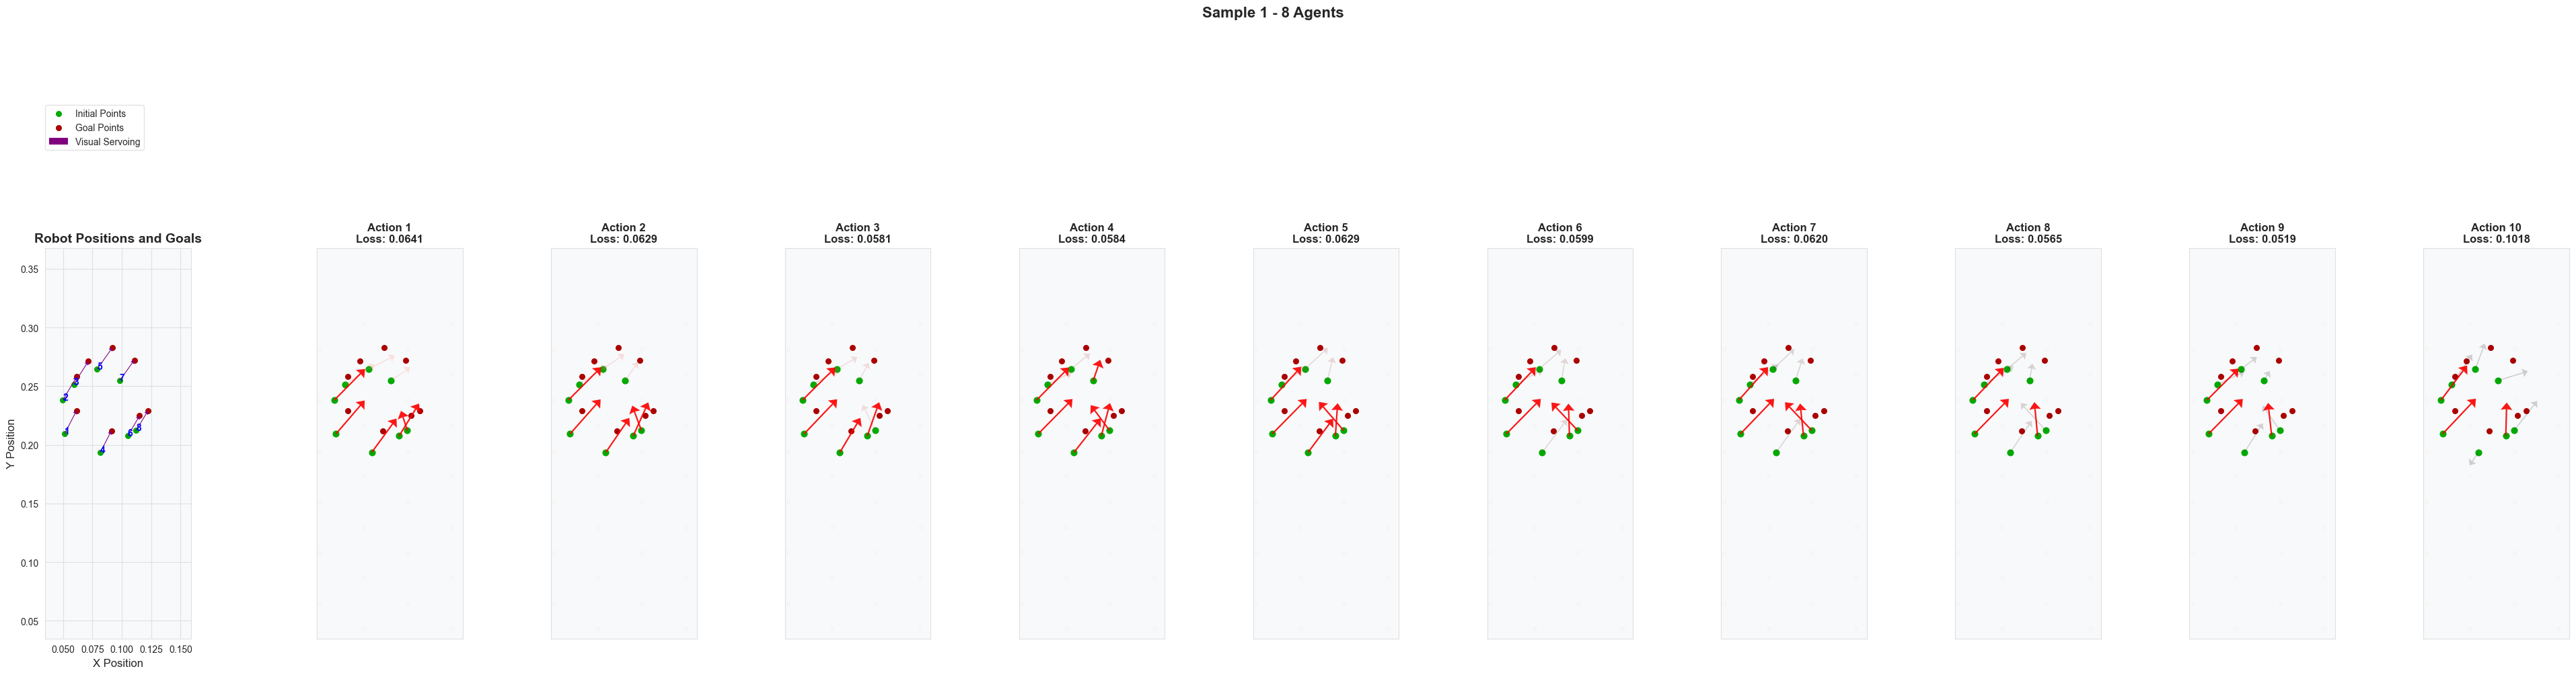

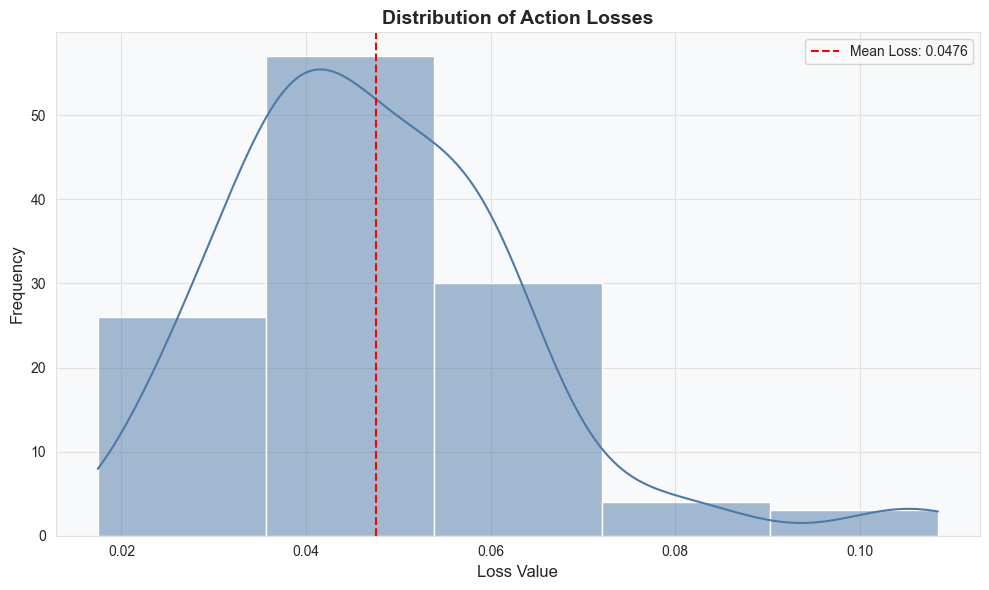

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# Set the style for better aesthetics
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.facecolor'] = '#f8f9fa'
plt.rcParams['axes.edgecolor'] = '#e0e0e0'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = '#e0e0e0'
plt.rcParams['grid.linestyle'] = '-'

# Custom colormap for actions
cmap = sns.color_palette("dark:salmon_r", as_cmap=True)
action_colors = [cmap(i/10) for i in range(15)]  # Sample 10 colors from the colormap

losses = []
for n, (state, actions_list, action_gt, pos) in enumerate(zip(statesss, actionsss, actions_gt, possss)):
    state = state.detach().cpu().numpy()
    actions_list = [action.detach().cpu().numpy() for action in actions_list]  # Assuming actionsss is a list of tensors
    action_gt = action_gt.detach().cpu().numpy()
    pos = pos.detach().cpu().numpy()
    
    num_actions = len(actions_list)
    
    for n_sample, idx in enumerate(range(state.shape[0])):
        print(n_sample, idx)
        po = pos[idx]
        n_agents = len([p for p in po if p != 0])
        r_poses = kdtree_positions_world[po[:n_agents]]
        init_pts = state[idx][:n_agents,:2] + r_poses
        goal_bd_pts = state[idx][:n_agents,2:4] + r_poses
        act_grsp = state[idx][:n_agents,4:6]
        act_gt_sample = action_gt[idx, :n_agents]
        r_poses2 = r_poses + act_grsp
        
        # Set fixed workspace boundaries (0.3m in X and 0.35m in Y)
        # Get center of workspace
        center_x = np.mean(kdtree_positions_world[:, 0])
        center_y = np.mean(kdtree_positions_world[:, 1])
        # Set boundaries based on center and dimensions (0.3m × 0.35m)
        # x_min, x_max = center_x - 0.15, center_x + 0.15
        # y_min, y_max = center_y - 0.175, center_y + 0.175
        
        
        r_poses3 = r_poses2 + act_gt_sample
        x_min, x_max = np.min(np.concatenate([goal_bd_pts[:, 0], init_pts[:, 0]])) * 0.7, np.max(np.concatenate([goal_bd_pts[:, 0], init_pts[:, 0]])) * 1.3
        y_min, y_max = np.min(np.concatenate([goal_bd_pts[:, 1], init_pts[:, 0]])) * 0.7, np.max(np.concatenate([goal_bd_pts[:, 1], init_pts[:, 0]])) * 1.3
        
        # Create figure with multiple subplots - larger figure with more equal subplot sizes
        fig = plt.figure(figsize=(40, 10), constrained_layout=True)
        gs = gridspec.GridSpec(1, num_actions + 1, width_ratios=[2] + [1.5] * num_actions)
        
        # Main plot with robot positions, initial points, and goal points
        ax_main = plt.subplot(gs[0])
        
        # # Plot robot positions with a custom colormap based on position
        # scatter = ax_main.scatter(
        #     kdtree_positions_world[:, 0], 
        #     kdtree_positions_world[:, 1], 
        #     # c=np.arange(len(kdtree_positions_world)), 
        #     cmap='Blues', 
        #     alpha=0.7, 
        #     s=30
        # )
        
        # Plot initial and goal points
        ax_main.scatter(init_pts[:, 0], init_pts[:, 1], c='#00aa00', s=30, label='Initial Points', zorder=3)
        for i, (x, y) in enumerate(zip(init_pts[:, 0], init_pts[:, 1])):
            ax_main.text(x, y, f'{i+1}', color='blue', fontsize=10, fontweight='bold', zorder=5)
            
        ax_main.scatter(goal_bd_pts[:, 0], goal_bd_pts[:, 1], c='#aa0000', s=30, label='Goal Points', zorder=3)
        
        # Plot ground truth actions as a reference - make them more visible
        delta_x = goal_bd_pts[:, 0] - init_pts[:, 0]
        delta_y = goal_bd_pts[:, 1] - init_pts[:, 1]
        # Plot arrows (servoing actions) directly from start to goal
        ax_main.quiver(init_pts[:, 0], init_pts[:, 1], delta_x, delta_y, 
                    color='purple', width=0.005, headwidth=6, scale_units='xy', 
                    scale=1, zorder=4, label='Visual Servoing')
        # ax_main.quiver(r_poses2[:, 0], r_poses2[:, 1], act_gt_sample[:, 0], act_gt_sample[:, 1], color='#000000', width=0.0075,headwidth=8,scale_units='xy', scale=1,label='Ground Truth', zorder=4)
        
        # Set plot properties
        ax_main.set_xlim(x_min, x_max)
        ax_main.set_ylim(y_min, y_max)
        ax_main.set_aspect('equal')
        ax_main.set_title('Robot Positions and Goals', fontsize=14, fontweight='bold')
        ax_main.set_xlabel('X Position', fontsize=12)
        ax_main.set_ylabel('Y Position', fontsize=12)
        ax_main.legend(loc=(0, 1.25), frameon=True, facecolor='white', edgecolor='#dddddd')
        
        # Action subplots without considering effect of 3rd variable
        for i, acts in enumerate(actions_list):
            act = acts[idx, :, :2]
            idxs = acts[idx, :, 2] < 0
            sel_act = act[idxs]
            
            # Calculate loss for this action
            loss = np.linalg.norm(act[:n_agents, :2] - act_gt_sample)
            losses.append(loss)
            
            # Create subplot
            ax_action = plt.subplot(gs[i+1])
            ax_action.scatter(kdtree_positions_world[:, 0], kdtree_positions_world[:, 1], c='#eeeeee', alpha=0.15, s=15)
            ax_action.scatter(r_poses2[:, 0], r_poses2[:, 1],c='#00aa00',s=40,zorder=2)
            
            ax_action.scatter(goal_bd_pts[:, 0], goal_bd_pts[:, 1], c='#aa0000', s=30, zorder=2)
            q = ax_action.quiver(r_poses2[:, 0], r_poses2[:, 1], act[:n_agents, 0], act[:n_agents, 1], 
                     color=cmap(i/max(1, num_actions-1)), width=0.0075, headwidth=8, 
                     scale_units='xy', scale=1, zorder=3, alpha=0.2)
            # Plot selected actions with enhanced color
            q_sel = ax_action.quiver(r_poses2[idxs, 0], r_poses2[idxs, 1], sel_act[:n_agents, 0], sel_act[:n_agents, 1], 
                                    color='red', width=0.01, headwidth=8, 
                                    scale_units='xy', scale=1, zorder=3, alpha=0.9)
            # q = ax_action.quiver(r_poses2[:, 0], r_poses2[:, 1], act[:n_agents, 0], act[:n_agents, 1], color=cmap(i/max(1, num_actions-1)), width=0.0075, headwidth=8, scale_units='xy', scale=1, zorder=3, alpha=0.2)
            # q = ax_action.quiver(r_poses2[idxs, 0], r_poses2[idxs, 1], sel_act[:n_agents, 0], sel_act[:n_agents, 1], color=cmap(i/max(1, num_actions-1)), width=0.01, headwidth=8, scale_units='xy', scale=1, zorder=3, alpha=0.7)
            
            # Set plot properties
            ax_action.set_xlim(x_min, x_max)
            ax_action.set_ylim(y_min, y_max)
            ax_action.set_aspect('equal')
            ax_action.set_title(f'Action {i+1}\nLoss: {loss:.4f}', fontsize=12, fontweight='bold')
            ax_action.set_xticks([])
            ax_action.set_yticks([])
            
        
        # Add a title for the entire figure
        plt.suptitle(f'Sample {n_sample+1} - {n_agents} Agents', fontsize=16, fontweight='bold', y=1)
        
        # Adjust layout
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(f'../../data/temp_vis/sample_{n}.png', bbox_inches='tight', dpi=300)
        plt.show()
    
    # if n+1 % 5 == 0:
    #     break

# Plot the distribution of losses
plt.figure(figsize=(10, 6))
sns.histplot(losses, kde=True, bins=5, color="#4e79a7")
plt.axvline(np.mean(losses), color='red', linestyle='--', label=f'Mean Loss: {np.mean(losses):.4f}')
plt.title('Distribution of Action Losses', fontsize=14, fontweight='bold')
plt.xlabel('Loss Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
from PIL import Image
import os

# Set your folder path here
folder_path = "../../data/temp_vis/"

# Get list of image files (adjust extensions as needed)
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

# Open images and store them in a list
images = [Image.open(os.path.join(folder_path, file)) for file in image_files]

# Calculate the maximum width and the total height for the new image
max_width = max(im.width for im in images)
total_height = sum(im.height for im in images)

# Create a new image with a white background (or choose a different color/mode as needed)
combined_image = Image.new('RGB', (max_width, total_height), color=(255, 255, 255))

# Paste each image into the new image
current_y = 0
for im in images:
    # If image width is less than max_width, you can choose to center it horizontally.
    combined_image.paste(im, (0, current_y))
    current_y += im.height

# Save the resulting image
combined_image.save("../../data/temp_vis/combined.jpg")